## <span style="font-family: Latin Modern Roman; font-size: 25px;"> 1. Exploratory Data Analysis </span>

In [1]:
import pandas as pd

polusa_balanced_2017_1 = pd.read_csv('/Users/sergiocuencanunez/TFG-BA/polusa_balanced/2017_1.csv', header = 0)
polusa_balanced_2017_2 = pd.read_csv('/Users/sergiocuencanunez/TFG-BA/polusa_balanced/2017_2.csv', header = 0)

polusa_balanced_2018_1 = pd.read_csv('/Users/sergiocuencanunez/TFG-BA/polusa_balanced/2018_1.csv', header = 0)
polusa_balanced_2018_2 = pd.read_csv('/Users/sergiocuencanunez/TFG-BA/polusa_balanced/2018_2.csv', header = 0)

polusa_balanced_2019_1 = pd.read_csv('/Users/sergiocuencanunez/TFG-BA/polusa_balanced/2019_1.csv', header = 0)
polusa_balanced_2019_2 = pd.read_csv('/Users/sergiocuencanunez/TFG-BA/polusa_balanced/2019_2.csv', header = 0)

In [2]:
polusa_balanced = pd.concat([polusa_balanced_2017_1, polusa_balanced_2017_2, polusa_balanced_2018_1, polusa_balanced_2018_2, polusa_balanced_2019_1, polusa_balanced_2019_2], axis = 0)
polusa_balanced.head()

,id,date_publish,outlet,headline,lead,body,authors,domain,url,political_leaning
0,55171935,2017-01-01 00:00:00,Los Angeles Times,Afghan refugees coming to California struggle ...,NaN,California's capital has emerged as a leading ...,Associated Press,www.latimes.com,http://www.latimes.com/local/lanow/la-me-ln-af...,LEFT
1,55208434,2017-01-01 00:00:00,NBC News,Minimum Wages Will Rise in Nearly Two Dozen St...,"Twenty-two states, plus the District of Columb...",Play Facebook\nTwitter\nGoogle Plus\nEmbed Tru...,Emma Margolin,www.nbcnews.com,http://www.nbcnews.com/news/us-news/minimum-wa...,CENTER
2,55172357,2017-01-01 00:00:00,Los Angeles Times,Fire engulfs Long Beach apartment unit; man fo...,NaN,A man was found dead as a fire engulfed an apa...,Rong-Gong Lin Ii,www.latimes.com,http://www.latimes.com/local/lanow/la-me-ln-lo...,LEFT
3,115892789,2017-01-01 00:00:00,ABC News,Obama Boosted White House Technology; Trump Se...,Obama Boosted White House Technology; Trump Se...,As Barack Obama began preparing to leave offic...,Abc News,abcnews.go.com,http://abcnews.go.com/Technology/wireStory/oba...,CENTER
4,4375253,2017-01-01 00:00:00,Fox News,Most residents evacuated by sinkhole could ret...,The new public works commissioner in a suburba...,The new public works commissioner in a suburba...,NaN,www.foxnews.com,http://www.foxnews.com/us/2017/01/01/most-resi...,RIGHT


### <span style="font-family: Latin Modern Roman; font-size: 23px;"> 1.1. Key Features to Use </span>

- Check for null values.

In [3]:
polusa_balanced.isna().sum()

id                        0
date_publish              0
outlet                    0
headline                 26
lead                  64944
body                      0
authors              172938
domain                    0
url                       0
political_leaning         0
dtype: int64

- Since only 26 rows are missing headlines in both datasets, we should drop them.
- Drop the lead column because summarizing the body captures essential information more effectively, making it redundant.
- Drop the authors column since it won’t be used in the recommendation pipeline.

In [4]:
# Drop rows with missing headlines
polusa_balanced = polusa_balanced.dropna(subset = ["headline"])

# Drop irrelevant columns
polusa_balanced = polusa_balanced.drop(columns = ["lead", "authors"])

- Remove `UNDEFINED` political leaning tag to ensure only well-classified political content is used for training, maintaining balanced political representation in recommendations.

In [5]:
polusa_balanced = polusa_balanced[polusa_balanced['political_leaning'] != 'UNDEFINED'].reset_index(drop = True)

In [6]:
polusa_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 668333 entries, 0 to 668332
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   id                 668333 non-null  int64 
 1   date_publish       668333 non-null  object
 2   outlet             668333 non-null  object
 3   headline           668333 non-null  object
 4   body               668333 non-null  object
 5   domain             668333 non-null  object
 6   url                668333 non-null  object
 7   political_leaning  668333 non-null  object
dtypes: int64(1), object(7)
memory usage: 40.8+ MB


### <span style="font-family: Latin Modern Roman; font-size: 23px;"> 1.2 Body Summarizing </span>

Need to summarize the body or the articles as it is very long:
- Reduce Noise: The original text often contains irrelevant or repetitive information. Summarization extracts key points, removing unnecessary content.
- Improve Efficiency: Shorter text makes the recommender system faster and more accurate.
- Better Similarity Calculation: Summaries help the model focus on core ideas, enhancing content-based recommendation quality.

In [7]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.text_rank import TextRankSummarizer

# Define sumy summarization function
def summarize_text(text, num_sentences = 3):
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summarizer = TextRankSummarizer()
    summary = summarizer(parser.document, num_sentences)
    return ' '.join([str(sentence) for sentence in summary])

# Define summarization function
def summarize_row(text):
    return summarize_text(text, num_sentences = 3)

In [8]:
from joblib import Parallel, delayed

# Set number of cores
num_cores = 8

# Apply parallel processing
results = Parallel(n_jobs = num_cores, backend = "loky")(delayed(summarize_row)(text) for text in polusa_balanced["body"])
polusa_balanced["body_summary"] = results
polusa_balanced["text"] = polusa_balanced["headline"] + " " + polusa_balanced["body_summary"]

### <span style="font-family: Latin Modern Roman; font-size: 23px;"> 1.3 Text Cleaning </span>

- Remove extra whitespaces: Remove leading, trailing, and extra spaces.
- Remove Special Characters: Eliminate non-alphanumeric characters (e.g., !@#$%) as they add noise.
- Convert to Lowercase: Standardize text for better token matching.
- Remove Stopwords: Remove common words (e.g., "the", "is") that don’t add significant meaning.
- Lemmatization: Reduce words to their base form (e.g., "running" → "run").

In [9]:
import re
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk

# Download required NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# Define the text cleaning function
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text, flags=re.I)

    # Remove special characters
    text = re.sub(r'\W', ' ', str(text))  

    # Remove single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)

    # Remove not alphabetical characters
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Tokenization
    tokens = word_tokenize(text)
    # Lemmatization and stop words removal
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 3]
    
    return tokens

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sergiocuencanunez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sergiocuencanunez/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sergiocuencanunez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
# Apply parallel processing for text cleaning
tokens_results = Parallel(n_jobs = num_cores, backend = "loky")(
    delayed(clean_text)(text) for text in polusa_balanced["text"]
)

polusa_balanced["tokens"] = tokens_results
polusa_balanced["text_cleaned"] = [" ".join(tokens) for tokens in tokens_results]

In [11]:
polusa_balanced.to_csv("../data/polusa_balanced.csv", index = False)

### <span style="font-family: Latin Modern Roman; font-size: 23px;"> 1.4 Bias Analysis </span>

- The goal is to analyze real-world selection biases.

In [2]:
import pandas as pd
polusa_balanced = pd.read_csv("../data/polusa_balanced.csv", header = 0)

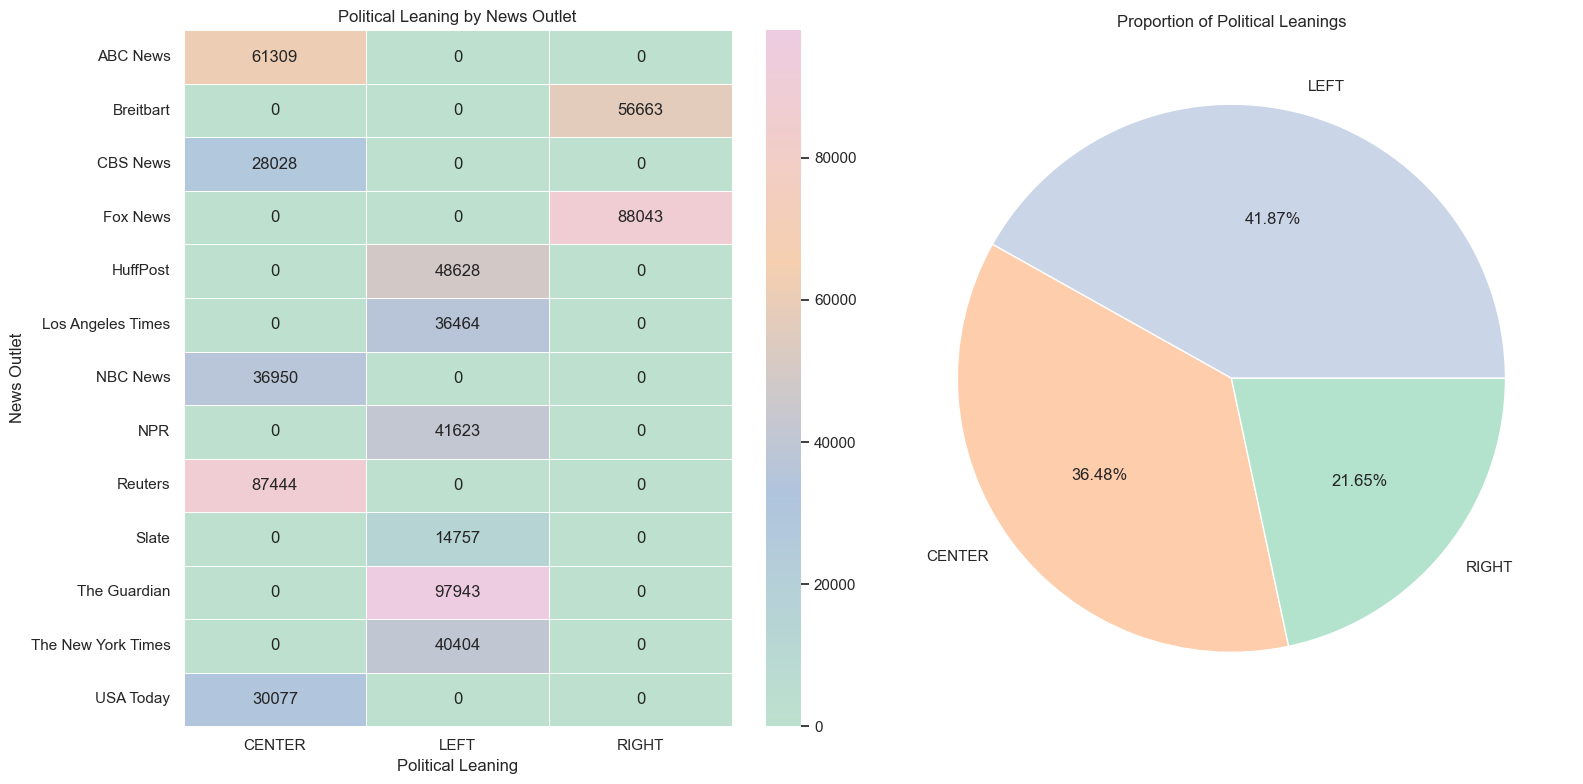

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set figure background transparent
sns.set_theme(style="whitegrid")

pastel_palette = sns.blend_palette(["#BDE1CE", "#B0C4DE", "#F5CFB0", "#EDCCE2"], as_cmap = True)
pastel2_colors = sns.color_palette("Pastel2")[:4]
political_color_map_pastel2 = {
    "RIGHT": pastel2_colors[0],
    "CENTER": pastel2_colors[1],
    "LEFT": pastel2_colors[2],
}

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Political Leaning by News Outlet
outlet_political_distribution = polusa_balanced.groupby(["outlet", "political_leaning"]).size().unstack(fill_value = 0)
sns.heatmap(outlet_political_distribution, cmap = pastel_palette, annot = True, fmt = "d", linewidths = 0.5, ax = axes[0])
axes[0].set_title("Political Leaning by News Outlet")
axes[0].set_xlabel("Political Leaning")
axes[0].set_ylabel("News Outlet")

# Proportion of Political Leanings
political_counts = polusa_balanced["political_leaning"].value_counts()
labels = political_counts.index
colors = [political_color_map_pastel2[label] for label in labels]
political_counts.plot(
    kind = "pie", autopct = '%1.2f%%', colors = colors, labels = labels, ax = axes[1]
)
axes[1].set_ylabel("")  # Remove 'Count' label
axes[1].set_title("Proportion of Political Leanings")

plt.tight_layout()
plt.show()

- **Selection Bias**: The dataset does not equally represent all perspectives. There are far fewer right-leaning outlets than center and left. The dataset is skewed towards LEFT (41.87%) and CENTER (36.48%), while RIGHT-leaning news is only 21.65%.
- **Media Bias**: Each news outlet has a strong editorial stance, reinforcing its own ideological leaning:
    - Reuters, ABC News, and USA Today dominate CENTER-leaning news.
    - The Guardian, HuffPost, and NPR dominate LEFT-leaning news.
    - Fox News and Breitbart dominate RIGHT-leaning news.
- **Unfairness Bias**: Could emerge if a recommendation system unintentionally prioritizes majority perspectives over minority ones.

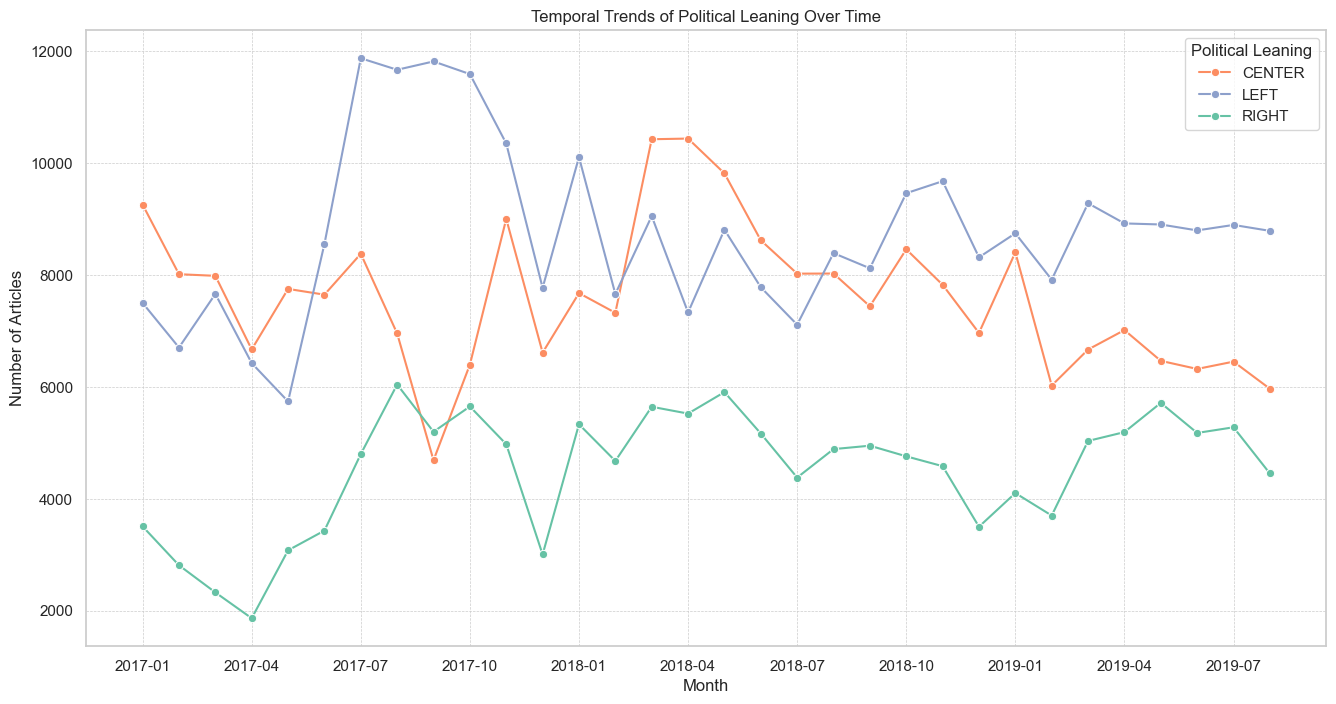

In [4]:
polusa_balanced["date_publish"] = pd.to_datetime(polusa_balanced["date_publish"])
polusa_balanced["year"] = polusa_balanced["date_publish"].dt.year
polusa_balanced["year_month"] = polusa_balanced["date_publish"].dt.to_period("M").astype(str)

monthly_distribution = polusa_balanced.groupby(["year_month", "political_leaning"]).size().reset_index(name = "count")
polusa_balanced['year_month'] = polusa_balanced['date_publish'].dt.to_period('M')

set2_colors = sns.color_palette("Set2")[:4]
political_color_map_set2 = {
    "RIGHT": set2_colors[0],
    "CENTER": set2_colors[1],
    "LEFT": set2_colors[2],
}

# Temporal Trends of Political Leaning Over Time
plt.figure(figsize=(16, 8))
ax = sns.lineplot(data = monthly_distribution, x = "year_month", y = "count", hue = "political_leaning", marker="o", palette = political_color_map_set2)
x_labels = monthly_distribution["year_month"].unique()
ax.set_xticks(x_labels[::3])
ax.legend(title = "Political Leaning")
plt.ylabel("Number of Articles")
plt.xlabel("Month")
plt.title("Temporal Trends of Political Leaning Over Time")
plt.grid(True, which = "both", ls = "--", linewidth = 0.5)
plt.show()

- **Exposure Bias**: Users are more likely to engage with articles that are already well-represented, leading to a reinforcing cycle where right-leaning content gets even less exposure.
- **Algorithmic Bias**: May emerge because models optimizing for engagement will prioritize already popular content, which is mostly LEFT or CENTER.

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sergiocuencanunez/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


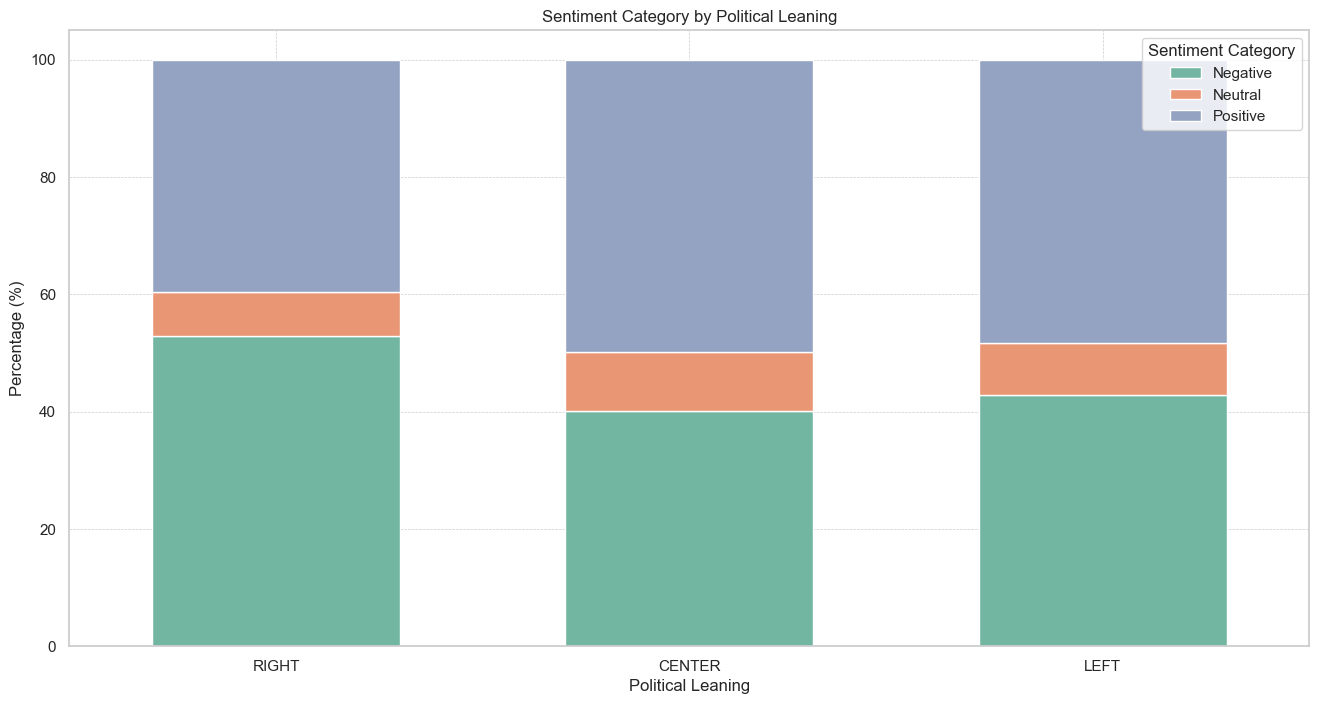

In [6]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Download NLTK sentiment lexicon if not already downloaded
nltk.download("vader_lexicon")
sia = SentimentIntensityAnalyzer()

# Compute sentiment score
polusa_balanced["text_sentiment"] = polusa_balanced["text_cleaned"].apply(lambda x: sia.polarity_scores(str(x))["compound"])

# Function to categorize sentiment
def categorize_sentiment(score):
    if score <= -0.2:
        return "Negative"
    elif score >= 0.2:
        return "Positive"
    else:
        return "Neutral"

# Apply categorization
polusa_balanced["sentiment_category"] = polusa_balanced["text_sentiment"].apply(categorize_sentiment)

# Compute sentiment distribution
sentiment_distribution = polusa_balanced.groupby(["political_leaning", "sentiment_category"]).size().unstack()
sentiment_distribution = sentiment_distribution.div(sentiment_distribution.sum(axis = 1), axis = 0) * 100
sentiment_palette = {"Negative": set2_colors[0], "Neutral": set2_colors[1], "Positive": set2_colors[2]}

# Sentiment Category by Political Leaning
plt.figure(figsize = (16, 8))

categories = ["RIGHT", "CENTER", "LEFT"]
sentiment_distribution = sentiment_distribution.reindex(categories)
bottom_values = None

for sentiment in ["Negative", "Neutral", "Positive"]:
    sns.barplot(x = sentiment_distribution.index, y = sentiment_distribution[sentiment], color = sentiment_palette[sentiment], label = sentiment, width = 0.6, bottom = bottom_values)
    bottom_values = sentiment_distribution[sentiment] if bottom_values is None else bottom_values + sentiment_distribution[sentiment]

plt.legend(title="Sentiment Category")
plt.title("Sentiment Category by Political Leaning")
plt.xlabel("Political Leaning")
plt.ylabel("Percentage (%)")
plt.grid(True, which = "both", ls = "--", linewidth = 0.5)
plt.show()

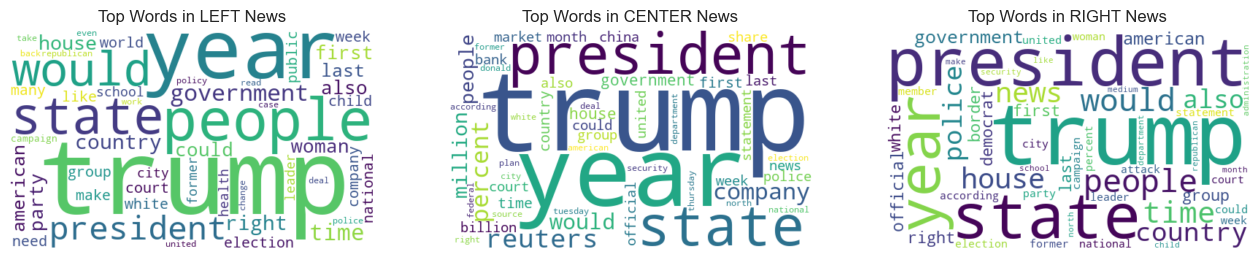

In [7]:
from collections import Counter
from wordcloud import WordCloud

leanings = ["LEFT", "CENTER", "RIGHT"]
excluded_words = {"said", "saying", "told", "says", "say", "report", "reported"}

# Top Words in News by Political Leaning
fig, axes = plt.subplots(1, 3, figsize = (16, 8))
for i, leaning in enumerate(leanings):
    text = " ".join(polusa_balanced[polusa_balanced["political_leaning"] == leaning]["text_cleaned"])
    filtered_words = [word for word in text.split() if word not in excluded_words]
    word_freq = Counter(filtered_words).most_common(50)    
    wordcloud = WordCloud(width = 500, height = 300, background_color = "white").generate_from_frequencies(dict(word_freq))    
    axes[i].imshow(wordcloud, interpolation="bilinear")
    axes[i].axis("off")
    axes[i].set_title(f"Top Words in {leaning} News")
plt.show()

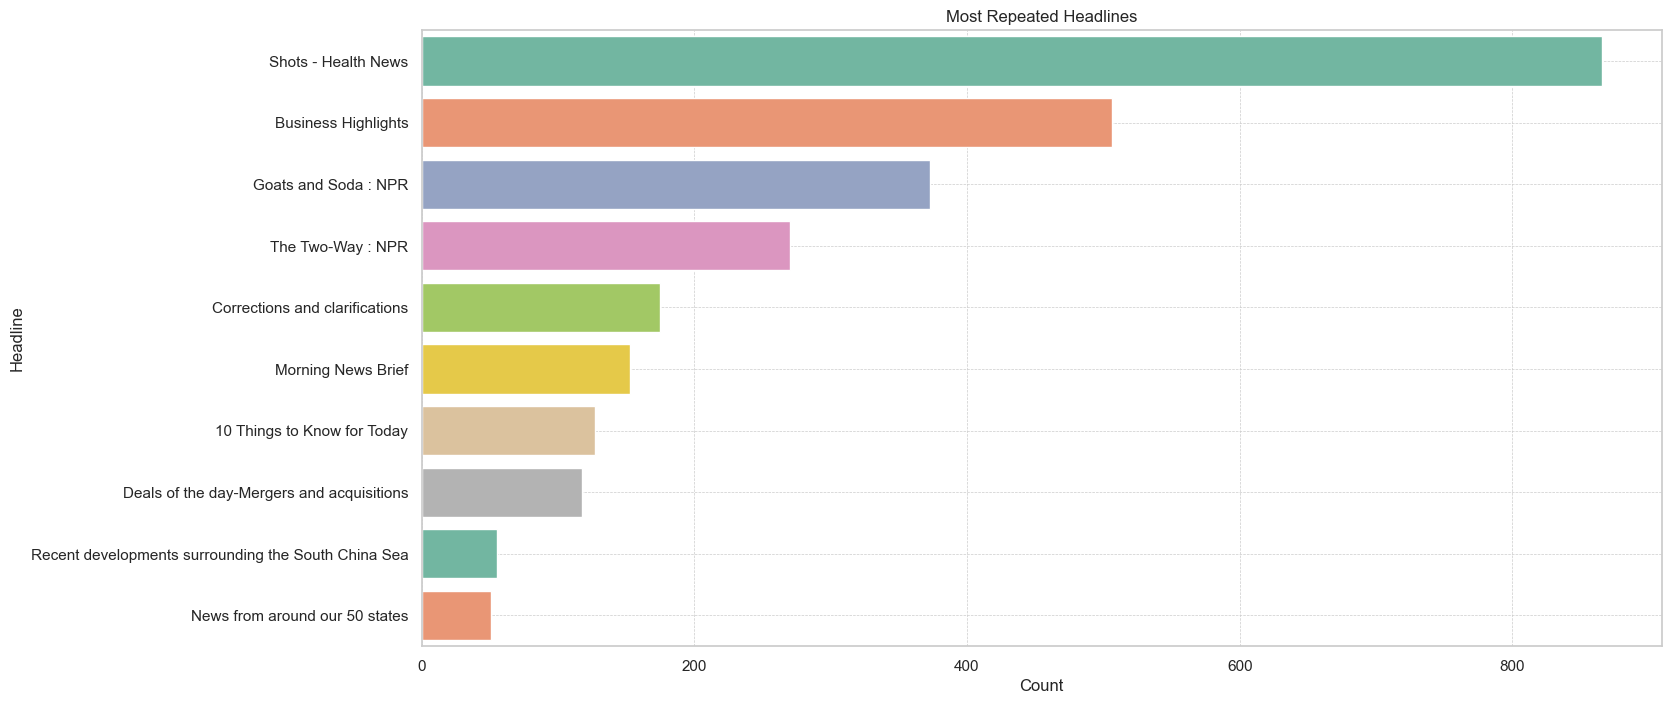

In [8]:
popular_articles = polusa_balanced["headline"].value_counts().nlargest(10)

plt.figure(figsize = (16, 8))
sns.barplot(x = popular_articles.values, y = popular_articles.index, hue = popular_articles.index, palette = "Set2")
plt.title("Most Repeated Headlines")
plt.xlabel("Count")
plt.ylabel("Headline")
plt.grid(True, which = "both", ls = "--", linewidth = 0.5)
plt.show()

---

## <span style="font-family: Latin Modern Roman; font-size: 25px;"> 2. News Recommender System (NRS) </span>

In [1]:
import pandas as pd

polusa_balanced = pd.read_csv('../data/polusa_balanced.csv', header = 0)

### <span style="font-family: Latin Modern Roman; font-size: 23px;"> 2.1 TF-IDF </span>

<div style="text-align: justify;">

 - TF-IDF matrices are usually sparse, meaning they contain many zero values, which makes computation faster.
 - Complexity: $O(N^2 · d)$  where d is the number of features (words).
 - For 400,000+ articles: It can take minutes to hours depending on the machine and the TF-IDF matrix sparsity.

Instead of computing all pairwise similarities, we use Nearest Neighbors Search for fast retrieval.
</div>

In [13]:
import pandas as pd
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

# Solves Popularity Bias and limits each outlet to appear at most `max_per_outlet`` times.
def fairness_re_ranking(recommendations, max_per_outlet = 2):
    outlet_counts = Counter()
    balanced_recommendations = []

    for _, row in recommendations.iterrows():
        if outlet_counts[row['outlet']] < max_per_outlet:
            balanced_recommendations.append(row)
            outlet_counts[row['outlet']] += 1

    return pd.DataFrame(balanced_recommendations).reset_index(drop = True)

# Enforces political diversity while keeping personalization strong.
def enforce_political_diversity(recommendations, primary_weight, top_n = 5):
    """
    - 2 articles from the same leaning as the input article.
    - 2 articles from opposite leanings (to ensure exposure to diversity).
    - 1 article from the least represented category.
    """
    
    # Identify the original article's leaning
    primary_leaning = recommendations.iloc[0]["political_leaning"]
    
    # Determine opposite and secondary leanings
    if primary_leaning == "LEFT":
        secondary_leanings = ["CENTER", "RIGHT"]
    elif primary_leaning == "RIGHT":
        secondary_leanings = ["CENTER", "LEFT"]
    else:
        secondary_leanings = ["LEFT", "RIGHT"]

    # Define target quotas
    quota = {primary_leaning: primary_weight}  # Ensure primary leaning gets at least `primary_weight` recommendations
    for secondary in secondary_leanings:
        quota[secondary] = (top_n - primary_weight) // 2  # Split remaining spots equally
    
    # Ensure at least one article from each category is included
    quota[secondary_leanings[0]] += 1

    selected_articles = []
    remaining_articles = recommendations.copy()

    # Enforce the adjusted quotas
    for leaning, min_count in quota.items():
        candidates = remaining_articles[remaining_articles["political_leaning"] == leaning].head(min_count)
        selected_articles.extend(candidates.to_dict("records"))
        remaining_articles = remaining_articles[~remaining_articles["id"].isin([a["id"] for a in selected_articles])]

    # Fill remaining slots if needed
    sorted_remaining = remaining_articles.to_dict("records")
    selected_articles.extend(sorted_remaining[:top_n - len(selected_articles)])

    return pd.DataFrame(selected_articles).reset_index(drop=True)

# Ensures fairness in recommendations by controlling outlet diversity and political diversity.
def recommend_articles_bias_controlled(article_id, df, primary_weight, top_n = 5, base_days_window = 5, max_days_window = 10):
    # Step 1: Get reference date & adaptively filter articles within the rolling window
    reference_date = pd.to_datetime(df.loc[df['id'] == article_id, 'date_publish']).values[0]
    reference_date = pd.to_datetime(reference_date).date()

    min_date = reference_date - pd.Timedelta(days = base_days_window)
    max_date = reference_date + pd.Timedelta(days = base_days_window)

    df['date_only'] = pd.to_datetime(df['date_publish']).dt.date
    time_filtered_df = df[(df['date_only'] >= min_date) & (df['date_only'] <= max_date)].copy()
    
    # Expand window if too few articles exist
    while len(time_filtered_df) < top_n * 3 and (max_date - reference_date).days < max_days_window:
        min_date -= pd.Timedelta(days = 1)
        max_date += pd.Timedelta(days = 1)
        time_filtered_df = df[(df['date_only'] >= min_date) & (df['date_only'] <= max_date)].copy()

    time_filtered_df = time_filtered_df.drop(columns = ['date_only']).reset_index(drop = True)

    # Step 2: Handle case where too few articles exist
    if len(time_filtered_df) < top_n:
        return time_filtered_df[['id', 'date_publish', 'headline', 'outlet', 'url', 'political_leaning']].head(top_n)

    # Step 3: Compute TF-IDF for time-filtered articles & fit Nearest Neighbors model
    vectorizer = TfidfVectorizer(max_features = 50_000)
    tfidf_filtered = vectorizer.fit_transform(time_filtered_df['text_cleaned'])

    nn_filtered = NearestNeighbors(n_neighbors = min(top_n * 3, len(time_filtered_df)), metric = 'cosine', algorithm = 'auto', n_jobs = -1)
    nn_filtered.fit(tfidf_filtered)

    # Step 4: Find correct index of article in filtered dataset
    idx_filtered = time_filtered_df.index[time_filtered_df['id'] == article_id].tolist()
    if not idx_filtered:
        return pd.DataFrame()
    idx_filtered = idx_filtered[0]

    # Step 5: Query Nearest Neighbors model (Get More Than Needed)
    distances, indices = nn_filtered.kneighbors(tfidf_filtered[idx_filtered])
    recommended_articles = time_filtered_df.iloc[indices[0][1:top_n * 3]].copy().reset_index(drop = True)

    # Step 6: Apply Political Diversity First
    recommended_articles = enforce_political_diversity(recommended_articles, top_n = top_n, primary_weight = primary_weight)

    # Step 7: Apply Fairness Re-Ranking (Prevent Outlet Dominance)
    recommended_articles = fairness_re_ranking(recommended_articles)

    # Step 8: Final Selection (Pick Top-N)
    recommended_articles = recommended_articles.head(top_n)
    recommended_articles = recommended_articles[['id', 'date_publish', 'headline', 'outlet', 'url', 'political_leaning']]
    
    return recommended_articles

In [18]:
test_article_id_left = 3952600
test_article_id_center = 115892789
test_article_id_right = 4398648

test_article_id = test_article_id_left
article_used = polusa_balanced.loc[polusa_balanced["id"] == test_article_id]
recommended_balanced = recommend_articles_bias_controlled(test_article_id, polusa_balanced, primary_weight = 2, top_n = 5)

print("Article Used for Recommendation:")
display(article_used[['id', 'date_publish', 'headline', 'outlet', 'url', 'political_leaning']].style.set_properties(subset = ['headline'], **{'width': '400px'}))

print("TF-IDF Bias-Controlled Recommendations:")
display(recommended_balanced.style.set_properties(subset = ['headline'], **{'width': '400px'}))

Article Used for Recommendation:


,id,date_publish,headline,outlet,url,political_leaning
215107,3952600,2017-11-14 18:56:13,Now There's An HIV Prevention App Specifically For Trans Women,HuffPost,https://www.huffingtonpost.com/entry/theres-an-app-for-that-too_us_5a0b38d4e4b006523921844c,LEFT


TF-IDF Bias-Controlled Recommendations:


,id,date_publish,headline,outlet,url,political_leaning
0,39141637,2017-11-17 14:56:44,Trans people already face a hostile world. Now the media is making it worse,The Guardian,https://www.theguardian.com/global/commentisfree/2017/nov/17/trans-people-children-suicide-bullying-rightwing-media,LEFT
1,3961302,2017-11-13 21:34:35,Critiquing Transgender Youtubers,HuffPost,https://www.huffingtonpost.com/entry/critiquing-transgender-youtubers_us_5a09f068e4b06d8966cf31d9,LEFT
2,55235860,2017-11-13 00:00:00,"Breast Cancer May Return Even 20 Years Later, Study Finds",NBC News,https://www.nbcnews.com/health/health-news/breast-cancer-may-return-even-20-years-later-study-finds-n819106?cid=public-rss_20171117,CENTER
3,55263464,2017-11-16 16:41:00,"OutFront: 'We need to keep fighting,' Transgender Day of Remembrance founder pleads",NBC News,https://www.nbcnews.com/feature/nbc-out/outfront-transgender-day-remembrance-founder-we-need-keep-fighting-n821361,CENTER
4,4340211,2017-11-10 07:19:37,Scotland Unveils Plans to Allow Children to Legally 'Change Gender',Breitbart,http://www.breitbart.com/london/2017/11/10/scotland-plans-children-change-gender/?utm_source=feedburner&utm_medium=feed&utm_campaign=Feed%3A+breitbart+%28Breitbart+News%29,RIGHT


In [19]:
def recommend_articles_unfiltered(article_id, df, top_n = 5, base_days_window = 5, max_days_window = 10):
    # Step 1: Get reference date & adaptively filter articles within the rolling window
    reference_date = pd.to_datetime(df.loc[df['id'] == article_id, 'date_publish']).values[0]
    reference_date = pd.to_datetime(reference_date).date()

    min_date = reference_date - pd.Timedelta(days = base_days_window)
    max_date = reference_date + pd.Timedelta(days = base_days_window)

    df['date_only'] = pd.to_datetime(df['date_publish']).dt.date
    time_filtered_df = df[(df['date_only'] >= min_date) & (df['date_only'] <= max_date)].copy()
    
    # Expand window if too few articles exist
    while len(time_filtered_df) < top_n * 3 and (max_date - reference_date).days < max_days_window:
        min_date -= pd.Timedelta(days = 1)
        max_date += pd.Timedelta(days = 1)
        time_filtered_df = df[(df['date_only'] >= min_date) & (df['date_only'] <= max_date)].copy()

    time_filtered_df = time_filtered_df.drop(columns = ['date_only']).reset_index(drop = True)

    # Step 2: Handle case where too few articles exist
    if len(time_filtered_df) < top_n:
        return time_filtered_df[['id', 'date_publish', 'headline', 'outlet', 'url', 'political_leaning']].head(top_n)

    # Step 3: Compute TF-IDF for time-filtered articles & fit Nearest Neighbors model
    vectorizer = TfidfVectorizer(max_features = 50_000)
    tfidf_filtered = vectorizer.fit_transform(time_filtered_df['text_cleaned'])

    nn_filtered = NearestNeighbors(n_neighbors = min(top_n * 3, len(time_filtered_df)), metric = 'cosine', algorithm='auto', n_jobs=-1)
    nn_filtered.fit(tfidf_filtered)

    # Step 4: Find correct index of article in filtered dataset
    idx_filtered = time_filtered_df.index[time_filtered_df['id'] == article_id].tolist()
    if not idx_filtered:
        return pd.DataFrame()
    idx_filtered = idx_filtered[0]

    # Step 5: Query Nearest Neighbors model (Get More Than Needed)
    distances, indices = nn_filtered.kneighbors(tfidf_filtered[idx_filtered])
    recommended_articles = time_filtered_df.iloc[indices[0][1:top_n * 3]].copy().reset_index(drop = True)

    # Step 6: Final Selection (Pick Top-N)
    recommended_articles = recommended_articles.head(top_n)

    return recommended_articles[['id', 'date_publish', 'headline', 'outlet', 'url', 'political_leaning']]

In [20]:
test_article_id_left = 3952600
test_article_id_center = 115892789
test_article_id_right = 4398648

test_article_id = test_article_id_left
article_used = polusa_balanced.loc[polusa_balanced["id"] == test_article_id]
recommended_balanced = recommend_articles_unfiltered(test_article_id, polusa_balanced, top_n = 5)

print("Article Used for Recommendation:")
display(article_used[['id', 'date_publish', 'headline', 'outlet', 'url', 'political_leaning']].style.set_properties(subset = ['headline'], **{'width': '400px'}))

print("TF-IDF Bias-Controlled Recommendations:")
display(recommended_balanced.style.set_properties(subset = ['headline'], **{'width': '400px'}))

Article Used for Recommendation:


,id,date_publish,headline,outlet,url,political_leaning
215107,3952600,2017-11-14 18:56:13,Now There's An HIV Prevention App Specifically For Trans Women,HuffPost,https://www.huffingtonpost.com/entry/theres-an-app-for-that-too_us_5a0b38d4e4b006523921844c,LEFT


TF-IDF Bias-Controlled Recommendations:


,id,date_publish,headline,outlet,url,political_leaning
0,39141637,2017-11-17 14:56:44,Trans people already face a hostile world. Now the media is making it worse,The Guardian,https://www.theguardian.com/global/commentisfree/2017/nov/17/trans-people-children-suicide-bullying-rightwing-media,LEFT
1,3961302,2017-11-13 21:34:35,Critiquing Transgender Youtubers,HuffPost,https://www.huffingtonpost.com/entry/critiquing-transgender-youtubers_us_5a09f068e4b06d8966cf31d9,LEFT
2,55235860,2017-11-13 00:00:00,"Breast Cancer May Return Even 20 Years Later, Study Finds",NBC News,https://www.nbcnews.com/health/health-news/breast-cancer-may-return-even-20-years-later-study-finds-n819106?cid=public-rss_20171117,CENTER
3,55183572,2017-11-17 00:00:00,"Transgender people are being killed at a record pace in U.S., advocacy groups say",Los Angeles Times,http://www.latimes.com/nation/nationnow/la-na-transgender-homicides-20171117-story.html,LEFT
4,39100207,2017-11-09 14:56:46,Legal recognition for non-binary people planned in Scotland,The Guardian,https://www.theguardian.com/society/2017/nov/09/legal-recognition-for-non-binary-people-planned-in-scotland,LEFT


---


## <span style="font-family: Latin Modern Roman; font-size: 25px;"> 3. Evaluation & Metrics </span>

### <span style="font-family: Latin Modern Roman; font-size: 23px;"> 3.1 KL Divergence (Kullback-Leibler Divergence) - Measuring Bias </span>

- KL Divergence measures how different one probability distribution is from another.
- In this case, it measures how different the recommended political leanings are from an ideal balanced distribution (33% LEFT, 33% CENTER, 33% RIGHT).
- A high KL divergence means the recommendations are skewed heavily toward one political leaning, creating an ideological filter bubble.

#### <span style="font-family: Latin Modern Roman; font-size: 21px;"> 3.1.1 Interpretation </span>

- KL = 0: The recommendation perfectly matches the ideal distribution.
- Low KL (~0.04 - 0.15): The recommendations are fairly balanced.
- Moderate KL (~0.4 - 0.6): Some bias exists, but it’s not extreme.
- High KL (~1.0 - 1.5): Strong bias, recommendations favor a single political leaning.

### <span style="font-family: Latin Modern Roman; font-size: 23px;"> 3.2 Shannon Entropy - Measuring Diversity </span>

- Shannon Entropy measures how diverse a set of recommendations is.
- A high entropy means recommendations are well-distributed across different political leanings, while a low entropy means recommendations are mostly from one political leaning.

#### <span style="font-family: Latin Modern Roman; font-size: 21px;"> 3.2.1 Interpretation </span>

- Entropy = 0: The recommendations are all from one political leaning (no diversity).
- Low Entropy (~0.5 - 0.6): Some diversity, but recommendations are still biased.
- High Entropy (~1.05 - 1.1): The recommendations are highly diverse (almost evenly split among LEFT, CENTER, and RIGHT).

In [21]:
import numpy as np
from scipy.stats import entropy

# Define the number of articles to sample for each political leaning
num_articles_per_leaning = 30

# Extract articles from different time frames to avoid overlapping recommendations
time_splits = np.array_split(polusa_balanced["date_publish"].sort_values().unique(), num_articles_per_leaning)

test_articles = {"LEFT": [], "CENTER": [], "RIGHT": []}

for time_range in time_splits:
    time_filtered_df = polusa_balanced[polusa_balanced["date_publish"].isin(time_range)]
    for leaning in test_articles.keys():
        selected_articles = time_filtered_df[time_filtered_df["political_leaning"] == leaning]["id"].sample(1, random_state=42).tolist()
        if selected_articles:
            test_articles[leaning].extend(selected_articles)

# Running the Analysis for Each Test Article
results = []

for leaning, article_ids in test_articles.items():
    for article_id in article_ids:
        # Get the Article Used for Recommendation
        article_used = polusa_balanced.loc[polusa_balanced["id"] == article_id]

        # Generate Recommendations
        recommended_naive = recommend_articles_unfiltered(article_id, polusa_balanced, top_n = 5)
        recommended_fairness_w2 = recommend_articles_bias_controlled(article_id, polusa_balanced, primary_weight = 2, top_n = 5)
        recommended_fairness_w3 = recommend_articles_bias_controlled(article_id, polusa_balanced, primary_weight = 3, top_n = 5)
        
        # Compute Political Leaning Distribution and Shannon Entropy
        def compute_bias_metrics(recommendations):
            political_counts = recommendations["political_leaning"].value_counts(normalize=True)
            shannon_entropy = entropy(political_counts)
            return political_counts, shannon_entropy

        naive_political_dist, naive_entropy = compute_bias_metrics(recommended_naive)
        fairness_political_dist, fairness_entropy_w2 = compute_bias_metrics(recommended_fairness_w2)
        fairness_political_dist, fairness_entropy_w3 = compute_bias_metrics(recommended_fairness_w3)

        # Compute KL Divergence
        ideal_distribution = {"LEFT": 0.33, "CENTER": 0.33, "RIGHT": 0.33}
        def get_distribution_vector(recommendations):
            actual_distribution = recommendations["political_leaning"].value_counts(normalize=True).to_dict()
            return [actual_distribution.get(k, 0) for k in ["LEFT", "CENTER", "RIGHT"]]

        kl_before = entropy(get_distribution_vector(recommended_naive), list(ideal_distribution.values()))
        kl_after_w2 = entropy(get_distribution_vector(recommended_fairness_w2), list(ideal_distribution.values()))
        kl_after_w3 = entropy(get_distribution_vector(recommended_fairness_w3), list(ideal_distribution.values()))

        # Store Results
        results.append({
            "Article ID": article_id,
            "Leaning": leaning,
            "KL Before": kl_before,
            "KL After Weight = 2": kl_after_w2,
            "KL After Weight = 3": kl_after_w3,
            "Shannon Entropy Before": naive_entropy,
            "Shannon Entropy After Weight = 2": fairness_entropy_w2,
            "Shannon Entropy After Weight = 3": fairness_entropy_w3
        })

# Convert to DataFrame for Analysis
results_df = pd.DataFrame(results)
results_df

,Article ID,Leaning,KL Before,KL After Weight = 2,KL After Weight = 3,Shannon Entropy Before,Shannon Entropy After Weight = 2,Shannon Entropy After Weight = 3
0,52939032,LEFT,0.598210,0.043692,0.425601,0.500402,1.054920,0.673012
1,38980517,LEFT,0.148342,0.043692,0.425601,0.950271,1.054920,0.673012
2,38937691,LEFT,0.598210,0.462098,0.462098,0.500402,0.636514,0.636514
3,4045748,LEFT,0.425601,0.043692,0.425601,0.673012,1.054920,0.673012
4,52972433,LEFT,0.425601,0.043692,0.425601,0.673012,1.054920,0.673012
...,...,...,...,...,...,...,...,...
85,4354651,RIGHT,0.598210,0.043692,0.425601,0.500402,1.054920,0.673012
86,4576372,RIGHT,0.148342,0.043692,0.425601,0.950271,1.054920,0.673012
87,4596867,RIGHT,0.598210,0.058892,0.058892,0.500402,1.039721,1.039721
88,4652788,RIGHT,0.148342,0.043692,0.425601,0.950271,1.054920,0.673012


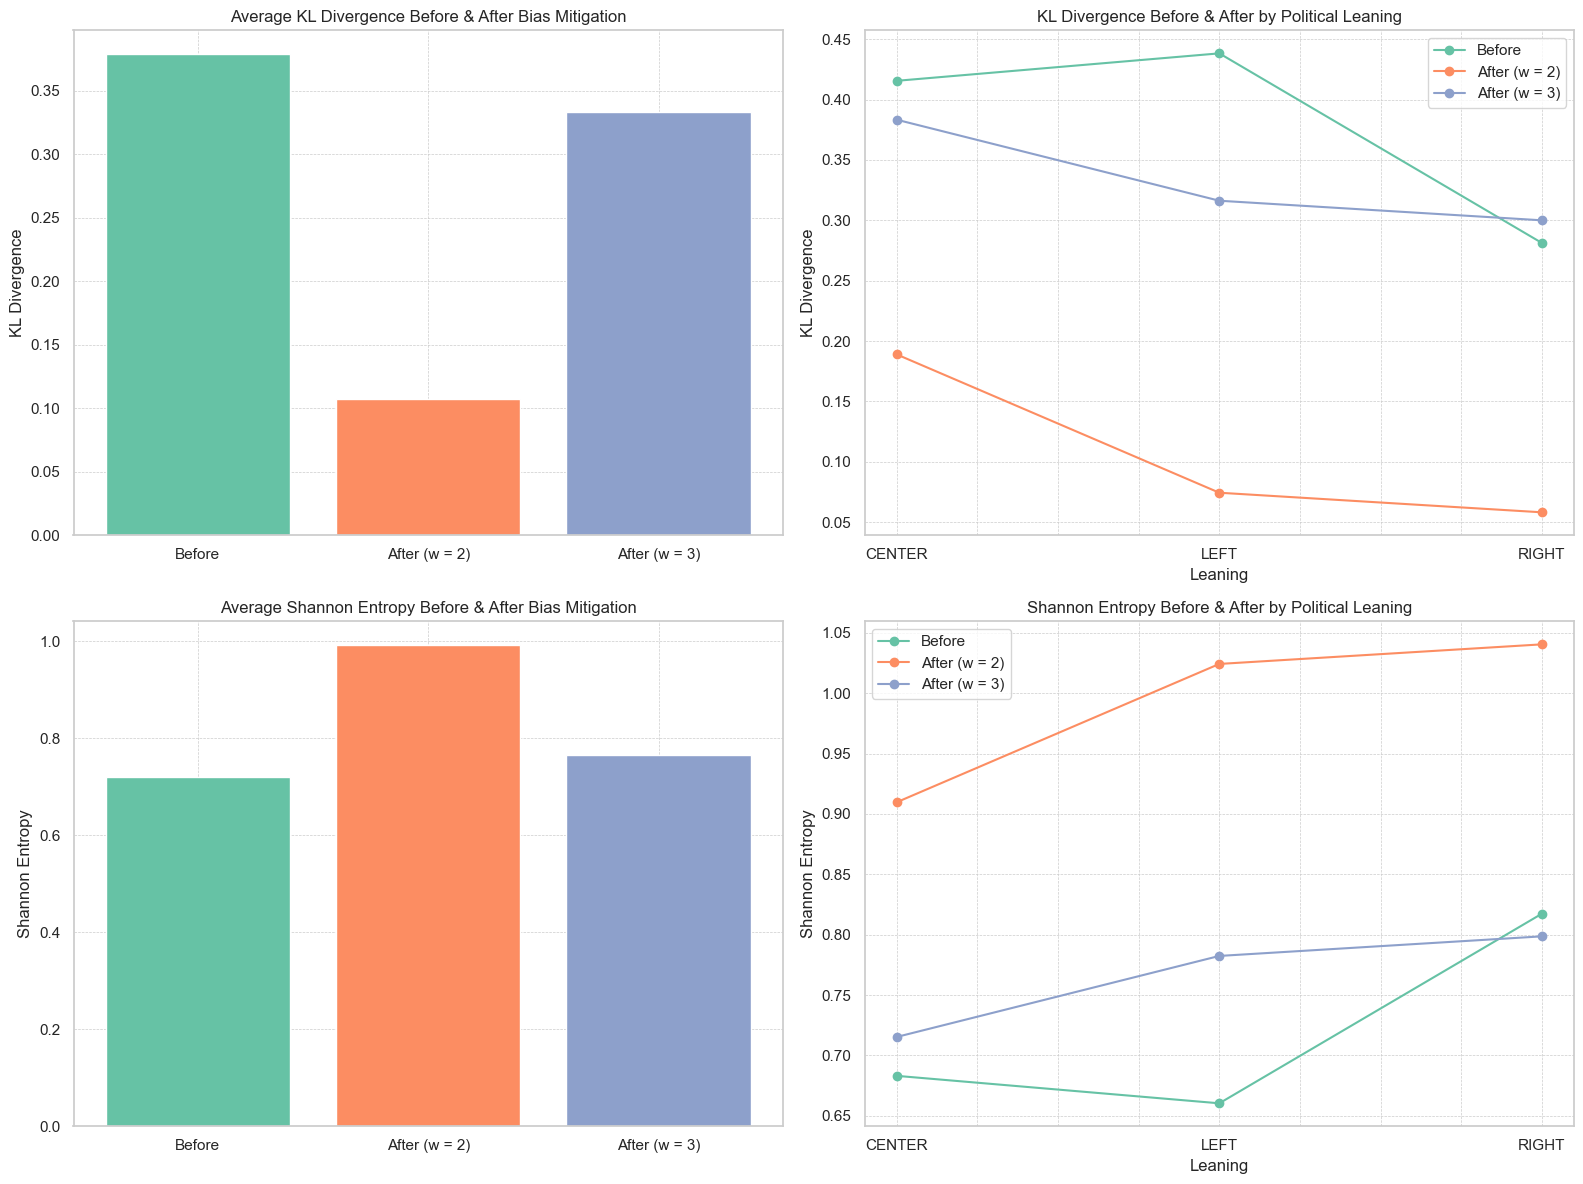

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute overall averages for KL Divergence and Shannon Entropy for both primary_weight=2 and 3
avg_kl_before = results_df["KL Before"].mean()
avg_kl_after_w2 = results_df["KL After Weight = 2"].mean()
avg_kl_after_w3 = results_df["KL After Weight = 3"].mean()

avg_entropy_before = results_df["Shannon Entropy Before"].mean()
avg_entropy_after_w2 = results_df["Shannon Entropy After Weight = 2"].mean()
avg_entropy_after_w3 = results_df["Shannon Entropy After Weight = 3"].mean()

# Compute averages by political leaning for both cases
avg_kl_by_leaning = results_df.groupby("Leaning")[["KL Before", "KL After Weight = 2", "KL After Weight = 3"]].mean()
avg_entropy_by_leaning = results_df.groupby("Leaning")[["Shannon Entropy Before", "Shannon Entropy After Weight = 2", "Shannon Entropy After Weight = 3"]].mean()

# Set color palette
sns.set_palette("Set2")

# Create a 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize = (16, 12))

# KL Divergence Before & After for both weights
axes[0, 0].bar(["Before", "After (w = 2)", "After (w = 3)"], [avg_kl_before, avg_kl_after_w2, avg_kl_after_w3], color = sns.color_palette("Set2")[:3])
axes[0, 0].set_ylabel("KL Divergence")
axes[0, 0].set_title("Average KL Divergence Before & After Bias Mitigation")
axes[0, 0].grid(True, linestyle = "--", linewidth = 0.5)

# KL Divergence by Political Leaning for both weights
avg_kl_by_leaning.plot(kind = "line", marker = 'o', ax = axes[0, 1])
axes[0, 1].set_ylabel("KL Divergence")
axes[0, 1].set_title("KL Divergence Before & After by Political Leaning")
axes[0, 1].legend(["Before", "After (w = 2)", "After (w = 3)"])
axes[0, 1].grid(True, linestyle = "--", linewidth = 0.5)

# Shannon Entropy Before & After for both weights
axes[1, 0].bar(["Before", "After (w = 2)", "After (w = 3)"], [avg_entropy_before, avg_entropy_after_w2, avg_entropy_after_w3], color = sns.color_palette("Set2")[:3])
axes[1, 0].set_ylabel("Shannon Entropy")
axes[1, 0].set_title("Average Shannon Entropy Before & After Bias Mitigation")
axes[1, 0].grid(True, linestyle = "--", linewidth = 0.5)

# Shannon Entropy by Political Leaning for both weights
avg_entropy_by_leaning.plot(kind = "line", marker = 'o', ax = axes[1, 1])
axes[1, 1].set_ylabel("Shannon Entropy")
axes[1, 1].set_title("Shannon Entropy Before & After by Political Leaning")
axes[1, 1].legend(["Before", "After (w = 2)", "After (w = 3)"])
axes[1, 1].grid(True, linestyle = "--", linewidth = 0.5)

# Adjust layout for readability
plt.tight_layout()
plt.show()
